SR: r(1) = 0.290
PCA: r(1) = 0.335
KNN: r(1) = 0.308
NN: r(1) = 0.344


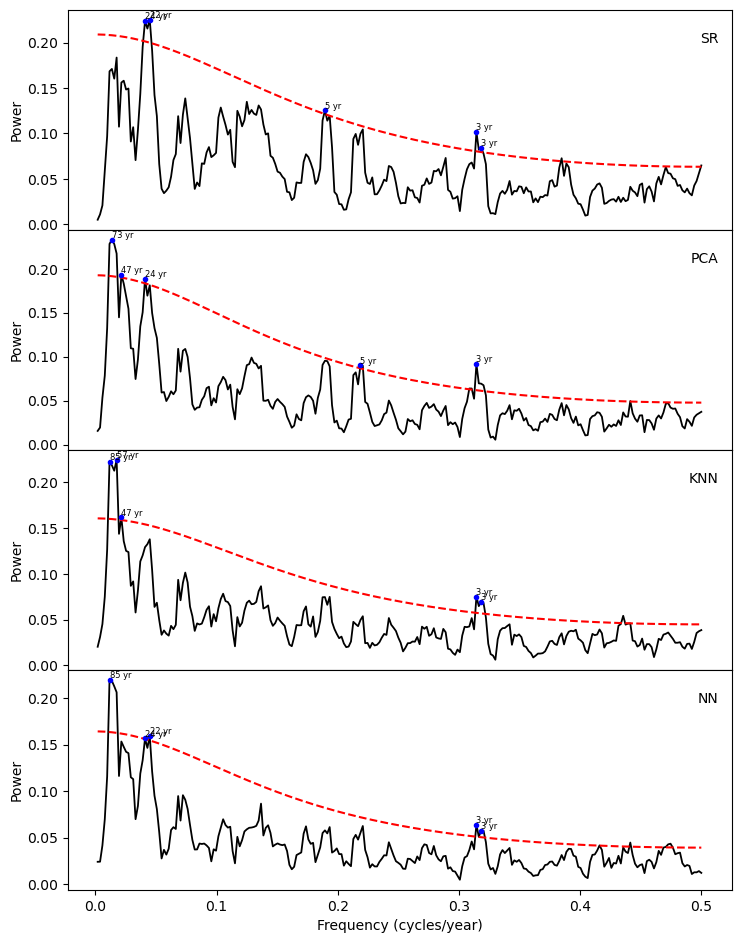

In [11]:
# =============================
# Helper functions
# =============================

import numpy as np
from scipy.signal.windows import dpss
from scipy.stats import chi2

def detrend_anomaly(y):
    """
    Remove linear trend and mean. Returns zero-mean anomalies.
    NOTE: Drops NaNs automatically.
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    x = np.arange(len(y), dtype=float)

    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]

    y_dt = y - (m * x + b)
    return y_dt - np.mean(y_dt)

def estimate_ar1(y):
    """
    Estimate lag-1 autocorrelation r1 (as correlation) and variance.
    Uses correlation rather than regression slope; clamps r1 for stability.
    NOTE: Drops NaNs automatically.
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    y = y - np.mean(y)

    var = np.var(y, ddof=1)

    if len(y) < 3:
        return np.nan, var

    r1 = np.corrcoef(y[:-1], y[1:])[0, 1]
    r1 = np.clip(r1, -0.99, 0.99)
    return r1, var

def ar1_red_noise_spectrum(var, r1, freqs, dt=1.0):
    """
    Theoretical AR(1) red-noise spectrum:
      S(f) = var*(1-r1^2) / (1 + r1^2 - 2*r1*cos(2*pi*f*dt))
    freqs: cycles per unit time (e.g., cycles/year when dt=1 year)
    """
    w = 2 * np.pi * freqs * dt
    #return var * (1 - r1**2) / (1 + r1**2 - 2 * r1 * np.cos(w))
    return var / (1 + r1**2 - 2 * r1 * np.cos(w))

def mtm_psd(y, dt=1.0, NW=3.0, K=None, adaptive=False, nfft=None):
    """
    Multitaper PSD with DPSS tapers.
    IMPORTANT: This version uses eigenvalue-weighted MTM (stable & review-proof).
    If you want true Thomson adaptive weighting, we can implement it later.

    Returns:
      freqs: cycles per unit time
      S_mtm: PSD
    """
    y = np.asarray(y, dtype=float)
    y = y[np.isfinite(y)]
    x = detrend_anomaly(y)

    N = len(x)
    if nfft is None:
        nfft = int(2 ** np.ceil(np.log2(N)))
    if K is None:
        K = int(2 * NW - 1)  # 5 for NW=3

    tapers, eigs = dpss(N, NW, K, return_ratios=True)

    Sk = []
    for k in range(K):
        Xk = np.fft.rfft(x * tapers[k], n=nfft)
        # Consistent PSD scaling (one-sided):
        Sk.append((dt / N) * (np.abs(Xk) ** 2))
    Sk = np.array(Sk)  # (K, nfreq)

    # Eigenvalue weights (sum to 1)
    wk = eigs[:, None] / np.sum(eigs)
    S_mtm = np.sum(wk * Sk, axis=0)

    freqs = np.fft.rfftfreq(nfft, d=dt)
    return freqs, S_mtm

def red_noise_significance(y, freqs_band, K, dt=1.0, alpha=0.05, S_band=None):
    """
    Compute AR(1) red-noise background and an (1-alpha) chi-square threshold.

    If S_band is provided, we scale AR(1) and threshold to match the MTM PSD level
    over the plotted band (robust against PSD normalization conventions).

    Returns:
      S_red_scaled, S_crit_scaled, r1
    """
    y_dt = detrend_anomaly(y)
    r1, var = estimate_ar1(y_dt)

    S_red = ar1_red_noise_spectrum(var, r1, freqs_band, dt=dt)

    dof = 2 * K
    S_crit = S_red * chi2.ppf(1 - alpha, dof) / dof

    
    if S_band is not None:
        denom = np.trapz(S_red, freqs_band)
        if np.isfinite(denom) and denom > 0:
            scale = np.trapz(S_band, freqs_band) / denom
            S_red *= scale
            S_crit *= scale

    return S_red, S_crit, r1


# =============================
# Plotting code
# =============================

import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

excel_path = "Reconstruction New.xlsx"
df = pd.read_excel(excel_path, header=0)

# Columns to analyze (1–4), col 0 = Year
cols_to_analyze = [1, 2, 3, 4]
method_labels  = ["SR", "PCA", "KNN", "NN"]

fig, axes = plt.subplots(len(cols_to_analyze), 1, figsize=(8, 10), sharex=True)

plt.subplots_adjust(
    hspace=0.0,
    top=0.96,
    bottom=0.08,
    left=0.12,
    right=0.95
)

dt, NW = 1.0, 3.0
K = 2 * int(NW) - 1  # 5 tapers

for idx, col in enumerate(cols_to_analyze):

    # 1) Extract years + flow
    years = pd.to_numeric(df.iloc[:, 0], errors="coerce").to_numpy()
    flow  = pd.to_numeric(df.iloc[:, col]/10e2, errors="coerce").to_numpy()

    # subset period 
    mask = (years >= 1490) & (years <= 1995)
    years, flow = years[mask], flow[mask]

    # drop NaNs after subsetting
    ok = np.isfinite(years) & np.isfinite(flow)
    years, flow = years[ok], flow[ok]

    # 2) MTM spectrum (use adaptive=False)
    freqs, S = mtm_psd(flow, dt=dt, NW=NW, K=K, adaptive=False)

    # keep 0–0.5 cpy band matching with Nyquist frequency
    band = (freqs > 0) & (freqs <= 0.5)
    freqs_band = freqs[band]
    S_band     = S[band]

    # 3) AR(1) red-noise + (1-alpha) threshold; scaled to match MTM band level
    S_red, S_sig95, r1 = red_noise_significance(
        flow, freqs_band, K=K, dt=dt, alpha=0.05, S_band=S_band
    )
    print(f"{method_labels[idx]}: r(1) = {r1:.3f}")


    # 4) Find up to 5 strongest *significant* local peaks in band
    peaks, _ = find_peaks(S_band)

    # keep only peaks above 95% threshold
    peaks = peaks[S_band[peaks] > S_sig95[peaks]]

    n_peaks = min(5, len(peaks))
    top = None
    if n_peaks > 0:
        top = peaks[np.argsort(S_band[peaks])[-n_peaks:]]
        top = top[np.argsort(freqs_band[top])]  # sort left->right by frequency

    # 5) Plot panel
    ax = axes[idx]
    ax.plot(freqs_band, S_band, lw=1.3, color="k")
    ax.plot(freqs_band, S_sig95, "--", color="r")

    # mark and label peaks
    if top is not None:
        for p in top:
            pf = freqs_band[p]
            pw = S_band[p]
            pp = 1.0 / pf
            ax.plot(pf, pw, "o", color="blue", markersize=3)
            ax.text(pf, pw, f"{pp:.0f} yr", fontsize=6, ha="left", va="bottom")

    # method label
    ax.text(0.98, 0.90, method_labels[idx], transform=ax.transAxes,
            ha="right", va="top")

    ax.set_ylabel("Power", labelpad=2)

    if idx < len(cols_to_analyze) - 1:
        ax.tick_params(labelbottom=False)

axes[-1].set_xlabel("Frequency (cycles/year)")
plt.show()
